# This notebook shows how to fit a linear resonator in the reflection configuration.

In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from resonator import background, reflection, see

Create data using the model plus gaussian noise. The model is the product of the reflection resonator model and a background model, which in this case assumes that the magnitude and phase are independent of frequency.

In [2]:
# Background parameters
background_model = background.MagnitudePhase()
magnitude = 0.01
phase = -np.pi / 2

# Foreground parameters
foreground_model = reflection.LinearReflection()
f_r = 1e9  # resonance frequency
df = 2e6  # frequency width
f = np.linspace(f_r - df / 2, f_r + df / 2, 501)
internal_loss = 1e-5  # Q_i = 100 000
coupling_loss = 5e-5  # Q_c = 20 000

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=f, magnitude=magnitude, phase=phase)
fg = foreground_model.func(frequency=f, resonance_frequency=f_r, internal_loss=internal_loss, coupling_loss=coupling_loss)

# The ideal data is the product of the background and foreground.
s21 = bg * fg

# The measured data will include noise
noise = 0.05 * magnitude
s21n = s21 + noise * (np.random.randn(s21.size) + 1j * np.random.randn(s21.size))

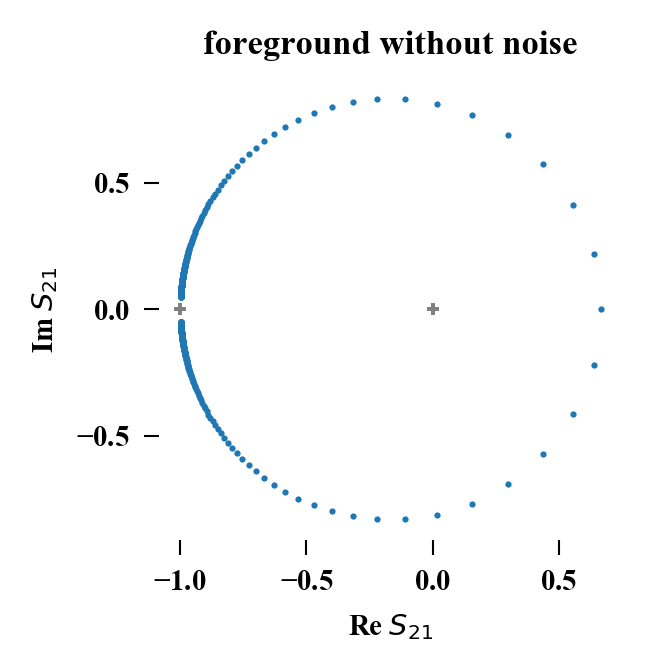

In [3]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(fg.real, fg.imag, '.')
ax.plot([0, -1], [0, 0], marker='P', linestyle='none', color='gray')
ax.set_title('foreground without noise');

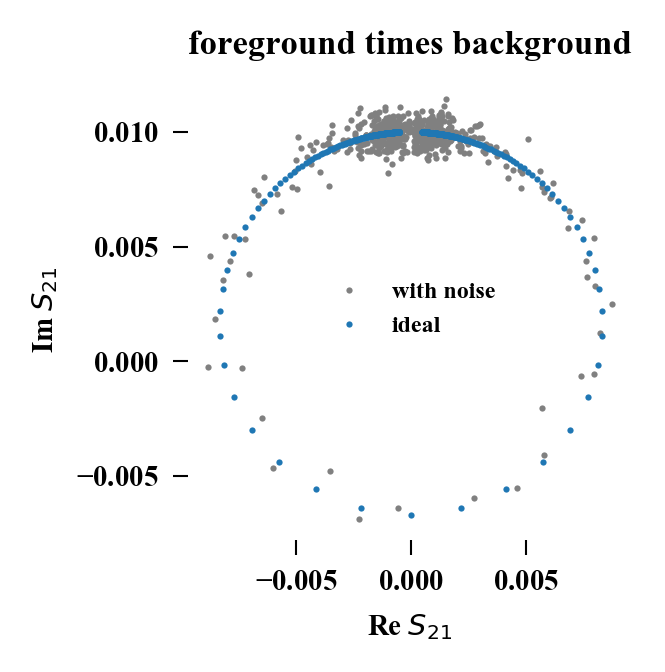

In [4]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(s21n.real, s21n.imag, '.', color='gray', label='with noise')
ax.plot(s21.real, s21.imag, '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

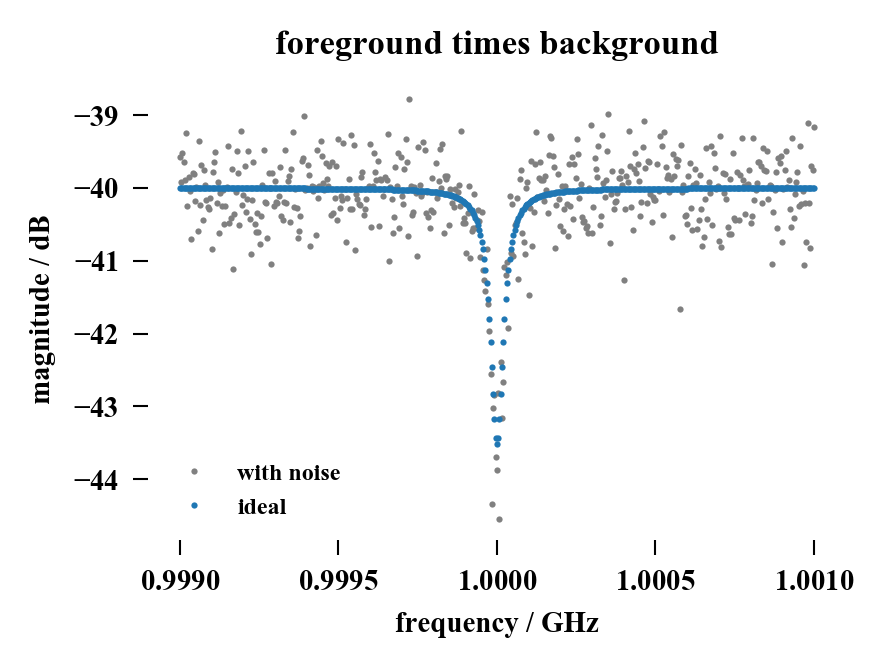

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('magnitude / dB')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21n)), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21)), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

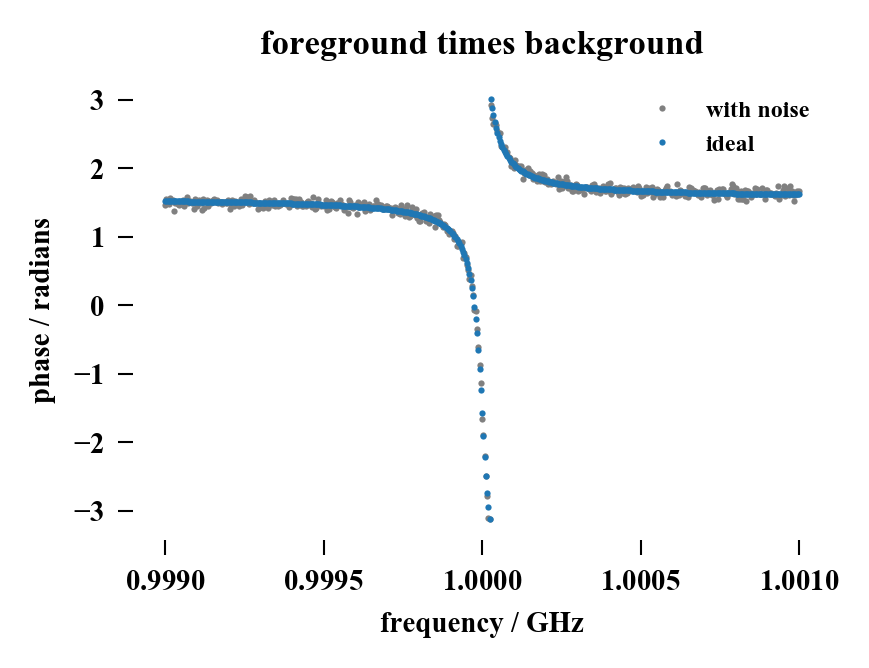

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('phase / radians')
ax.plot(1e-9 * f, np.angle(s21n), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, np.angle(s21), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

## Fit the model to the data using a LinearReflectionFitter.

Here, we know the standard error of each data point because we added the noise. If no errors are given, the fitting assumes equal errors for each point and thus equal weights, so errors are not generally necessary unless they vary between points.

In [7]:
# The MagnitudePhase background is the default for this fitter, so it doesn't need to be specified here.
resonator = reflection.LinearReflectionFitter(frequency=f, data=s21n, errors=(1 + 1j) * noise * np.ones(f.size))
print(resonator.result.fit_report())  # result is a lmfit.model.ModelResult object

[[Model]]
    (Model(magnitude_phase) * Model(linear_reflection))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 1002
    # variables        = 5
    chi-square         = 981.591571
    reduced chi-square = 0.98454521
    Akaike info crit   = -10.6191313
    Bayesian info crit = 13.9296351
[[Variables]]
    magnitude:            0.01000009 +/- 2.3256e-05 (0.23%) (init = 0.01068003)
    phase:               -1.56722263 +/- 0.00232255 (0.15%) (init = -1.573991)
    resonance_frequency:  1.0000e+09 +/- 266.276996 (0.00%) (init = 1e+09)
    internal_loss:        1.0896e-05 +/- 5.5933e-07 (5.13%) (init = 2.934701e-05)
    coupling_loss:        4.9889e-05 +/- 4.4586e-07 (0.89%) (init = 5.465299e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(magnitude, internal_loss)     =  0.257
    C(phase, resonance_frequency)   = -0.252
    C(internal_loss, coupling_loss) =  0.188



## How well do the fit values match the actual values, given the fit standard errors?

In [8]:
print("Normalized deviations: |fit_value - true_value| / fit_standard_error")
print("f_r: {:.2f}".format(abs(resonator.f_r - f_r) / resonator.f_r_error))
print("Q_c: {:.2f}".format(abs(resonator.Q_c - 1 / coupling_loss) / resonator.Q_c_error))
print("Q_i: {:.2f}".format(abs(resonator.Q_i - 1 / internal_loss) / resonator.Q_i_error))
print("magnitude: {:.2f}".format(abs(resonator.magnitude - magnitude) / resonator.magnitude_error))
print("phase: {:.2f}".format(abs(resonator.phase - phase) / resonator.phase_error))

Normalized deviations: |fit_value - true_value| / fit_standard_error
f_r: 0.53
Q_c: 0.25
Q_i: 1.75
magnitude: 0.00
phase: 1.54


## Plot the data

Use the `see.py` fitting module to plot the data, model, and resonance.

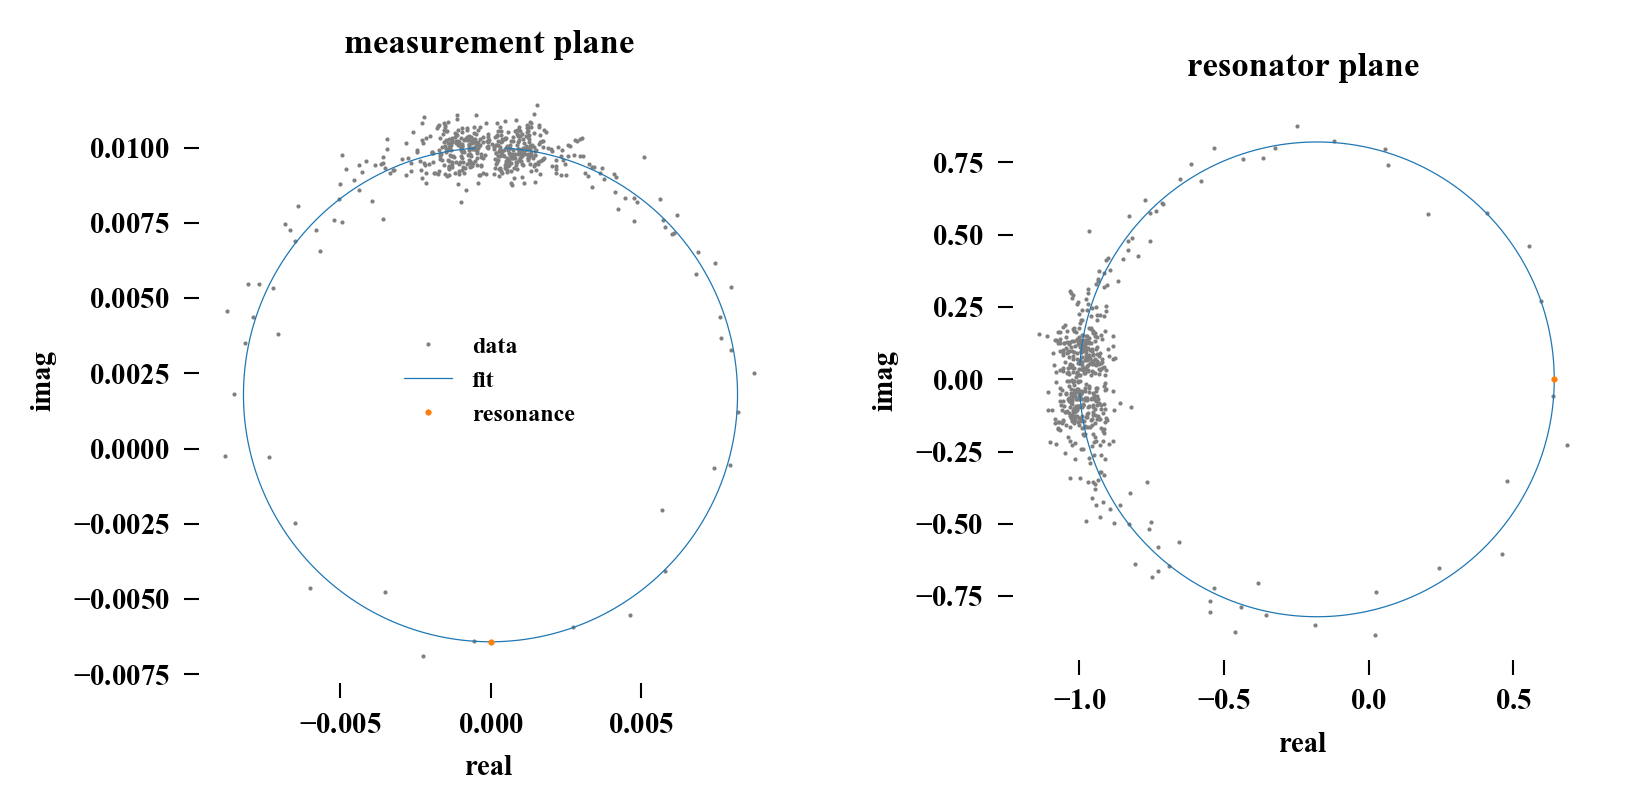

In [9]:
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)  # Adjust these values for your plot settings
ax_raw.set_title('measurement plane')
ax_norm.set_title('resonator plane')
see.real_and_imaginary(resonator=resonator, axes=ax_raw, normalize=False)
see.real_and_imaginary(resonator=resonator, axes=ax_norm, normalize=True)
ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');

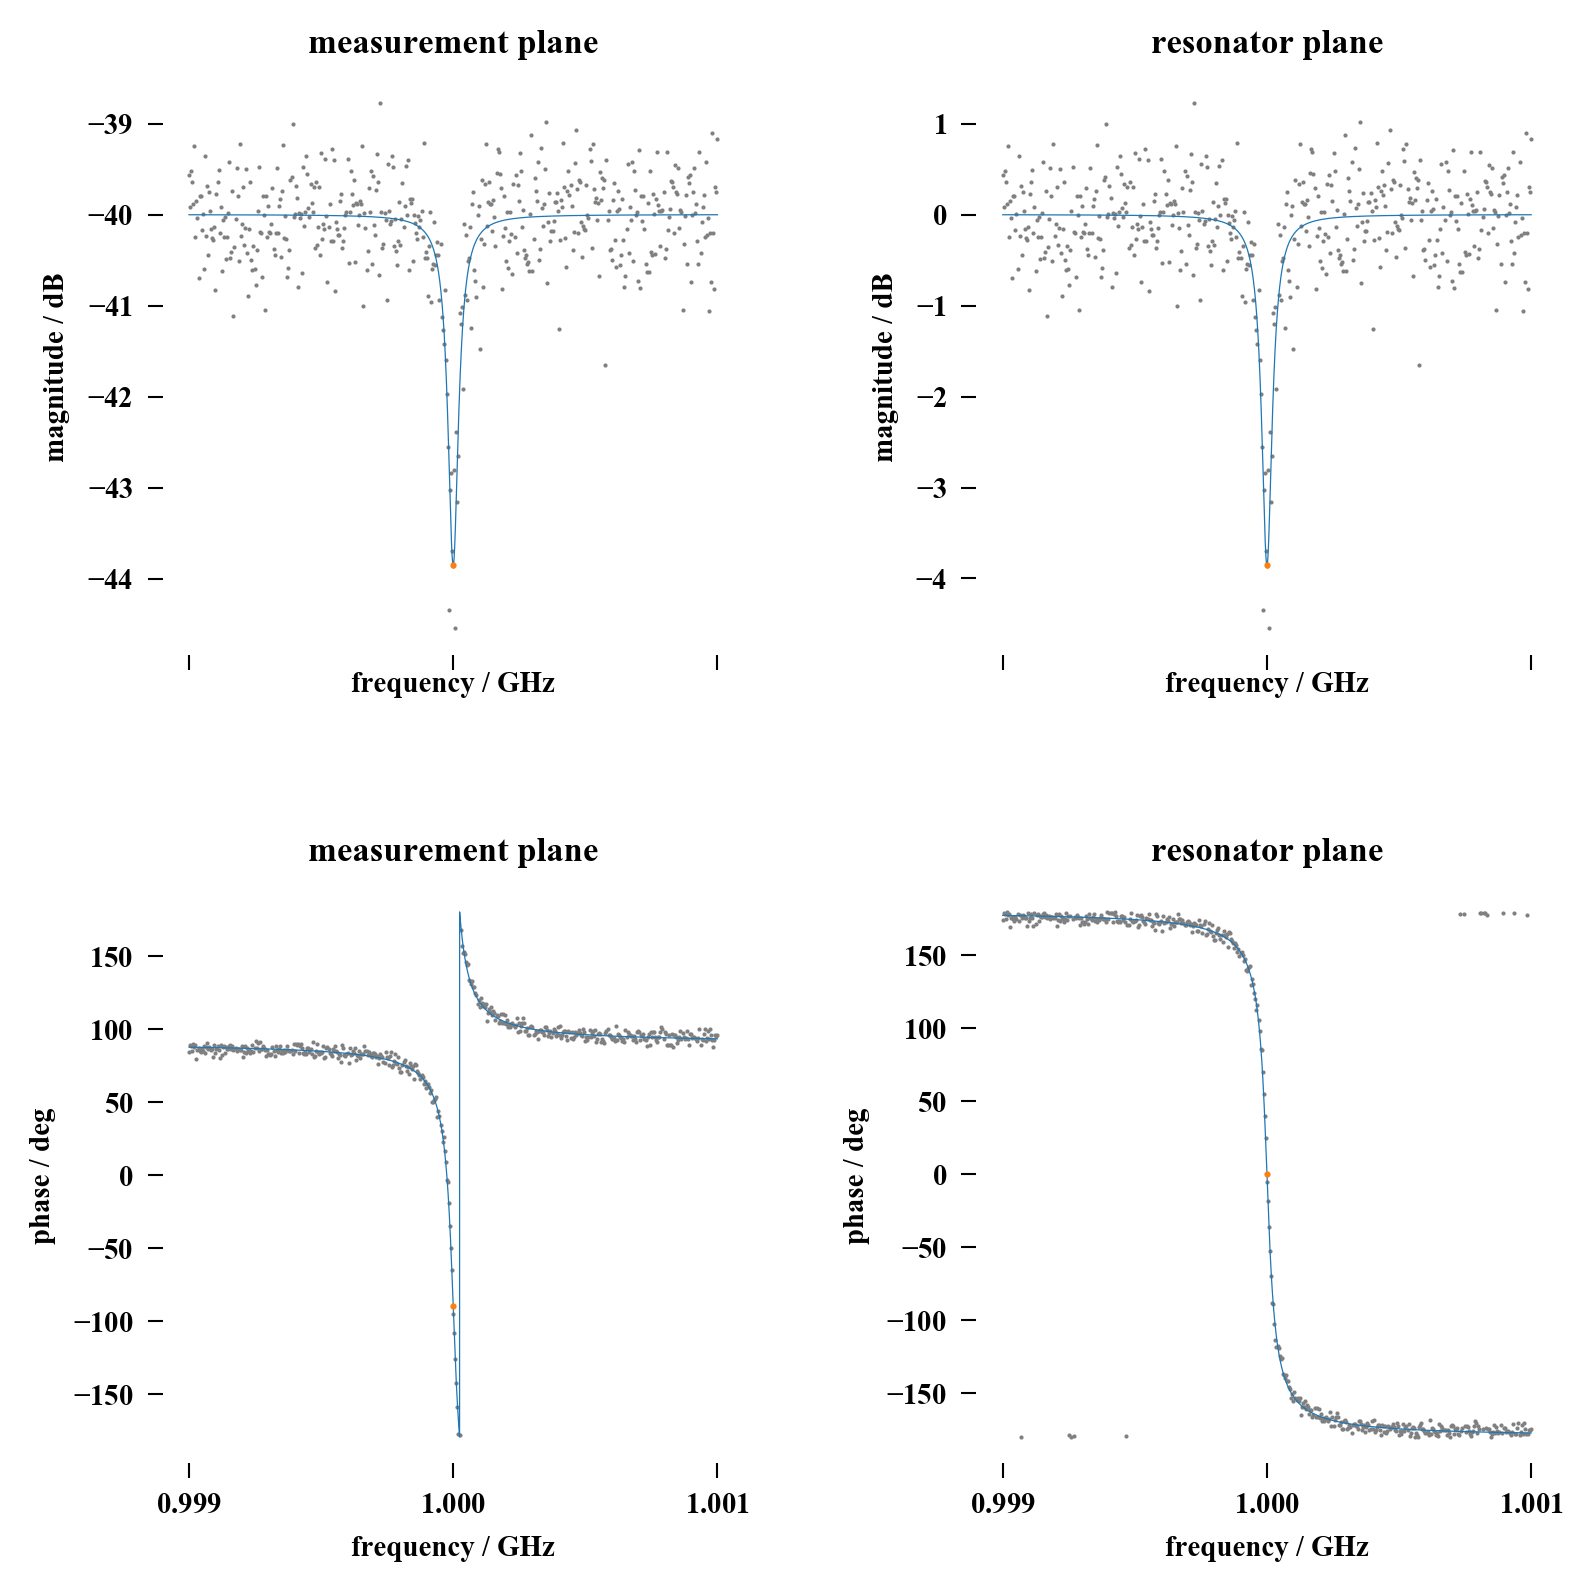

In [10]:
fig, axes = plt.subplots(2, 2, sharex='all', figsize=(6, 6), dpi=300)  # Adjust these values for your plot settings
ax_raw_mag, ax_norm_mag, ax_raw_phase, ax_norm_phase = axes.flatten()
ax_raw_mag.set_title('measurement plane')
ax_norm_mag.set_title('resonator plane')
ax_raw_phase.set_title('measurement plane')
ax_norm_phase.set_title('resonator plane')
see.magnitude_vs_frequency(resonator=resonator, axes=ax_raw_mag, normalize=False, frequency_scale=1e-9)
see.magnitude_vs_frequency(resonator=resonator, axes=ax_norm_mag, normalize=True, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_raw_phase, normalize=False, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_norm_phase, normalize=True, frequency_scale=1e-9);